# **BBC News - Text Classification**

In [27]:
import pandas as pd
df = pd.read_csv('https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/bbc-text.csv')

In [28]:
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


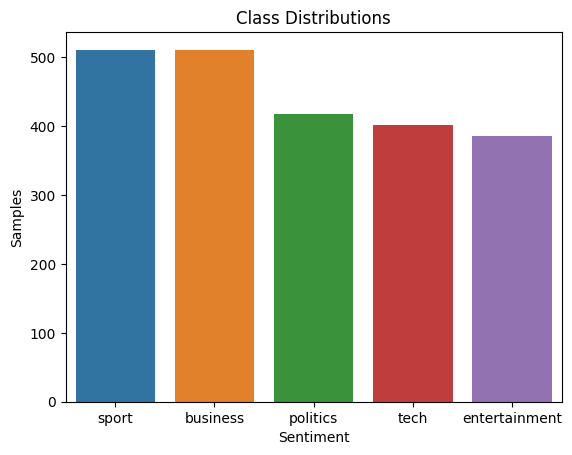

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
x = df.category.value_counts()
sns.barplot(x=x.index, y=x)
plt.gca().set_title('Class Distributions')
plt.gca().set_ylabel('Samples')
plt.gca().set_xlabel('Sentiment')
plt.show()

In [30]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


## **One Hot Encoding <br>**
karena data kategorik

In [32]:
Label = pd.get_dummies(df["category"])
new_df = pd.concat([df, Label], axis=1)
new_df = new_df.drop(columns=['category'])
new_df

,text,business,entertainment,politics,sport,tech
0,tv future in the hands of viewers with home th...,0,0,0,0,1
1,worldcom boss left books alone former worldc...,1,0,0,0,0
2,tigers wary of farrell gamble leicester say ...,0,0,0,1,0
3,yeading face newcastle in fa cup premiership s...,0,0,0,1,0
4,ocean s twelve raids box office ocean s twelve...,0,1,0,0,0
...,...,...,...,...,...,...
2220,cars pull down us retail figures us retail sal...,1,0,0,0,0
2221,kilroy unveils immigration policy ex-chatshow ...,0,0,1,0,0
2222,rem announce new glasgow concert us band rem h...,0,1,0,0,0
2223,how political squabbles snowball it s become c...,0,0,1,0,0


In [33]:
text = new_df['text'].values
label = new_df.iloc[:, 1:].values

In [34]:
print(len(text))
print(len(label))

2225
2225


## **Split Dataset (Train dan Test)**

In [35]:
from sklearn.model_selection import train_test_split
text_latih, text_test, label_latih, label_test = train_test_split(text, label, test_size=0.2)

## **Preprocessing Data <br>**
Menghilangkan stop word, tanda baca, dan lemmatization

In [36]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
nltk_tokenizer = nltk.RegexpTokenizer(r"\w+") #menghilangkan tanda baca
lemmatizer = WordNetLemmatizer()

filtered_latih = []
filtered_test = []

def processing(token, list_token):
  for string in token:
      word_tokens = word_tokenize(string)
      filtered_sentence = [lemmatizer.lemmatize(w.lower()) for w in word_tokens if w not in stop_words and w.isalpha()]
      filtered_sentence = ' '.join(filtered_sentence)

      new_sentences = nltk_tokenizer.tokenize(filtered_sentence)
      new_sentences = ' '.join(new_sentences)
      # processed_text =  re.sub(r'[^a-zA-Z\s]', '', new_sentences)
      # processed_text = re.sub(r'http\S+', '', processed_text)
      list_token.append(new_sentences)
  return list_token

filtered_latih = processing(text_latih, filtered_latih)
filtered_test = processing(text_test, filtered_test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Tokenizer**

In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token='<oov>')
tokenizer.fit_on_texts(filtered_latih)
tokenizer.fit_on_texts(filtered_test)

sekuens_latih = tokenizer.texts_to_sequences(filtered_latih)
sekuens_test = tokenizer.texts_to_sequences(filtered_test)

padded_latih = pad_sequences(sekuens_latih, padding='post', maxlen=100)
padded_test = pad_sequences(sekuens_test, padding='post', maxlen=100)

## **Setting Model**

In [38]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16, input_length=100),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax'),
])

In [39]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
from keras.callbacks import Callback, EarlyStopping

class MyCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.93) and (logs.get('accuracy')>0.90):
      self.model.stop_training = True
callback = MyCallback()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20)

## **Training Model**

In [41]:
history = model.fit(padded_latih,
                    label_latih,
                    epochs = 75,
                    validation_data = (padded_test, label_test),
                    verbose = 2,
                    callbacks = [callback, early_stopping])

Epoch 1/75
56/56 - 9s - loss: 1.5968 - accuracy: 0.2320 - val_loss: 1.6045 - val_accuracy: 0.2045 - 9s/epoch - 160ms/step
Epoch 2/75
56/56 - 3s - loss: 1.1278 - accuracy: 0.4910 - val_loss: 1.1755 - val_accuracy: 0.6899 - 3s/epoch - 49ms/step
Epoch 3/75
56/56 - 2s - loss: 0.3508 - accuracy: 0.8764 - val_loss: 0.6417 - val_accuracy: 0.9034 - 2s/epoch - 36ms/step
Epoch 4/75
56/56 - 2s - loss: 0.1068 - accuracy: 0.9657 - val_loss: 0.3954 - val_accuracy: 0.9079 - 2s/epoch - 28ms/step
Epoch 5/75
56/56 - 1s - loss: 0.0456 - accuracy: 0.9860 - val_loss: 0.3378 - val_accuracy: 0.9011 - 1s/epoch - 19ms/step
Epoch 6/75
56/56 - 1s - loss: 0.0585 - accuracy: 0.9815 - val_loss: 0.3091 - val_accuracy: 0.9146 - 1s/epoch - 18ms/step
Epoch 7/75
56/56 - 1s - loss: 0.0238 - accuracy: 0.9921 - val_loss: 0.3236 - val_accuracy: 0.9146 - 1s/epoch - 19ms/step
Epoch 8/75
56/56 - 1s - loss: 0.0113 - accuracy: 0.9961 - val_loss: 0.3473 - val_accuracy: 0.9146 - 1s/epoch - 26ms/step
Epoch 9/75
56/56 - 1s - loss: 0

## **Visualisasi Accuracy dan Loss**

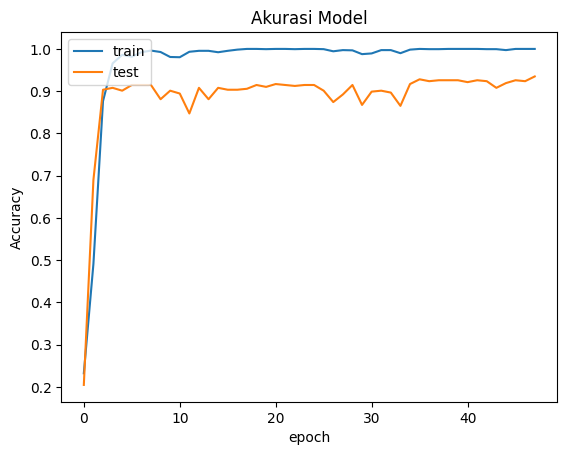

In [42]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

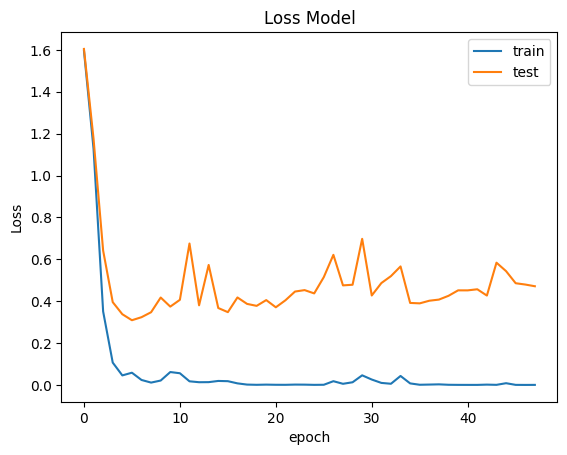

In [43]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()